# Description

Here I do the same as the previous notebook, but with the GLS model proposed in PhenoPLIER using the full correlation matrix (instead of the one with genes within a distnace of 5mb only).

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "1000g_eur"
    / "covars"
    / "_corrs_all"
    / "gls-gtex_v8_mashr-sub_corr"
)
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-gtex_v8_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Load MultiXcan genes present in results

In [5]:
_tmp = pd.read_csv(
    conf.RESULTS["GLS_NULL_SIMS"]
    / "twas"
    / "smultixcan"
    / "random.pheno0-gtex_v8-mashr-smultixcan.txt",
    sep="\t",
)

In [6]:
_tmp.shape

(22317, 18)

In [7]:
_tmp.head()

,gene,gene_name,pvalue,n,n_indep,p_i_best,t_i_best,p_i_worst,t_i_worst,eigen_max,eigen_min,eigen_min_kept,z_min,z_max,z_mean,z_sd,tmi,status
0,ENSG00000131941.7,RHPN2,0.000040,48.0,3.0,2.139470e-04,Artery_Tibial,0.990132,Brain_Nucleus_accumbens_basal_ganglia,36.556432,7.692089e-16,2.519701,-2.721185,3.701952,1.283152,1.825567,3.0,0
1,ENSG00000076650.6,GPATCH1,0.000078,40.0,3.0,4.534390e-04,Brain_Cerebellum,0.817384,Brain_Frontal_Cortex_BA9,29.990208,2.086487e-15,1.815203,-3.506853,2.383485,-2.016745,1.715495,3.0,0
2,ENSG00000100906.10,NFKBIA,0.000096,1.0,1.0,9.591208e-05,Brain_Frontal_Cortex_BA9,0.000096,Brain_Frontal_Cortex_BA9,1.000000,1.000000e+00,1.000000,-3.900707,-3.900707,-3.900707,NaN,1.0,0
3,ENSG00000136319.11,TTC5,0.000109,47.0,5.0,1.402826e-03,Brain_Hippocampus,0.961887,Colon_Sigmoid,21.272442,8.142339e-16,0.732606,-3.194069,1.397514,-0.916662,1.068989,5.0,0
4,ENSG00000152990.13,ADGRA3,0.000135,41.0,12.0,3.211289e-07,Heart_Atrial_Appendage,0.653657,Whole_Blood,12.988248,3.499412e-16,0.444682,-5.110605,3.599410,-0.464735,2.316607,12.0,0


In [8]:
multixcan_genes = set(_tmp["gene_name"])
display(len(multixcan_genes))
display(list(multixcan_genes)[:10])

22311

['SLC4A5',
 'L1TD1',
 'FEM1C',
 'GSC2',
 'SLC6A7',
 'SEPSECS',
 'CAPS',
 'EXO1',
 'NPAS4',
 'DNPH1']

# Load MultiPLIER Z matrix

In [9]:
multiplier_z = pd.read_pickle(conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"])

In [10]:
multiplier_z.shape

(6750, 987)

In [11]:
# keep genes only present in MultiXcan
multiplier_z = multiplier_z.loc[
    sorted(multixcan_genes.intersection(multiplier_z.index))
]

In [12]:
multiplier_z.shape

(6446, 987)

In [13]:
multiplier_z.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
A2M,0.000000,0.000000,0.000000,0.078428,0.0,0.00000,0.000000,0.046772,0.000000,0.011033,...,0.010910,0.000000,0.052869,0.012749,0.0,0.013982,0.152241,0.000000,0.000000,0.108884
AAAS,0.271162,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,1.513337,0.000000,...,0.000000,0.000000,0.000000,0.001385,0.0,0.000000,0.711896,0.030534,0.447105,0.424685
AANAT,0.005099,0.308497,0.028815,0.000000,0.0,0.00000,0.371725,0.000000,0.135238,0.000000,...,0.117163,0.018815,0.000000,0.193142,0.0,0.040401,0.180436,0.000000,0.000000,0.042064
AARS,0.512978,0.000000,0.451285,0.319568,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006208,0.021274,0.0,0.000000,0.062143,0.000000,0.000000,0.364892
AARS2,1.008157,0.000000,0.197424,0.024832,0.0,0.57081,0.000000,0.228675,0.000000,0.116243,...,0.000000,0.000000,0.153345,0.000000,0.0,0.000000,1.004578,0.014470,0.000000,0.000000


# Functions

In [14]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [15]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [16]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [17]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [18]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel("$-\log_{10}$" + f"(expected pvalue) - {other_lv}")
        ax.set_ylabel("$-\log_{10}$" + f"(observed pvalue) - {observed_lv}")

        # ax.set_title("OLS (baseline)\nMean type I error: 5.5%")
        ax.set_title("OLS (baseline)")

In [19]:
def get_lv_genes(lv_code):
    lv_genes = multiplier_z[lv_code].sort_values(ascending=False)
    lv_obj = LVAnalysis(lv_code)
    return lv_obj.lv_genes.set_index("gene_name").loc[lv_genes.index]

# Get files list

In [20]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-gtex_v8_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-gtex_v8_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-gtex_v8_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-gtex_v8_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-gtex_v8_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [21]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [22]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [23]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [24]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [25]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV136,0.393254,0.127056,3.095131,0.001976,0.000988,random.pheno988
1,LV175,0.330666,0.125839,2.627689,0.008617,0.004309,random.pheno988
2,LV816,0.327034,0.126016,2.595168,0.009476,0.004738,random.pheno988
3,LV585,0.324859,0.126181,2.574544,0.010059,0.005030,random.pheno988
4,LV116,0.336875,0.131120,2.569217,0.010215,0.005108,random.pheno988


In [26]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [27]:
show_prop(dfs)

0.05445187436676798

# QQ-plot

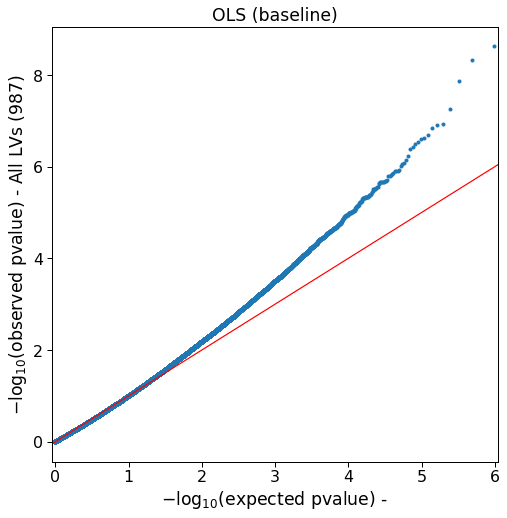

In [28]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [29]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [30]:
summary_df.shape

(987, 4)

In [31]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.021,0.057
1,LV10,0.012,0.034,0.068
2,LV100,0.014,0.051,0.084
3,LV101,0.011,0.039,0.090
4,LV102,0.013,0.055,0.080


In [32]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.014128,0.054452,0.100803
std,0.004983,0.012501,0.018391
min,0.001000,0.016000,0.049000
25%,0.011000,0.045500,0.088000
50%,0.014000,0.054000,0.100000
75%,0.018000,0.062000,0.113000
max,0.034000,0.105000,0.176000


## LVs with expected type I error

In [33]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(88, 4)

,lv,1,5,10
334,LV40,0.018,0.049,0.097
828,LV845,0.012,0.049,0.093
431,LV488,0.012,0.049,0.099
767,LV790,0.013,0.049,0.099
324,LV391,0.013,0.049,0.096
838,LV854,0.016,0.049,0.086
843,LV859,0.013,0.049,0.086
760,LV784,0.011,0.049,0.082
754,LV779,0.011,0.049,0.091
251,LV325,0.015,0.049,0.095


,lv,1,5,10
204,LV283,0.009,0.051,0.096
212,LV290,0.017,0.051,0.098
219,LV297,0.014,0.051,0.087
247,LV321,0.011,0.051,0.103
252,LV326,0.011,0.051,0.088
297,LV367,0.014,0.051,0.096
303,LV372,0.016,0.051,0.094
320,LV388,0.011,0.051,0.102
383,LV444,0.020,0.051,0.090
414,LV472,0.015,0.051,0.094


## LVs with high type I error

In [34]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(289, 4)

,lv,1,5,10
200,LV28,0.025,0.082,0.130
310,LV379,0.022,0.082,0.121
672,LV704,0.016,0.082,0.144
417,LV475,0.023,0.083,0.144
341,LV406,0.019,0.084,0.132
253,LV327,0.027,0.084,0.130
892,LV902,0.028,0.084,0.136
151,LV235,0.027,0.085,0.135
752,LV777,0.021,0.085,0.153
694,LV724,0.029,0.086,0.143


# Comparison with OLS model

## LVs with high mean type I error in OLS model

Here I compare the OLS's high mean type I error LVs with results from the GLS model.

### LV234

In [35]:
lv_code = "LV234"

In [36]:
results = dfs[dfs["lv"] == lv_code]

In [37]:
results.shape

(1000, 7)

In [38]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
516,LV234,-0.026556,0.144691,-0.183532,0.854386,0.572807,random.pheno988
1873,LV234,-0.179261,0.145092,-1.235500,0.216690,0.891655,random.pheno589
2911,LV234,-0.217875,0.144715,-1.505549,0.132232,0.933884,random.pheno385
3639,LV234,-0.069849,0.144824,-0.482301,0.629609,0.685196,random.pheno5
4378,LV234,0.014162,0.144892,0.097744,0.922139,0.461069,random.pheno74


#### Mean type I errors at different thresholds

In [39]:
show_prop(results, 0.01)

0.014

In [40]:
show_prop(results, 0.05)

0.053

In [41]:
show_prop(results, 0.10)

0.089

In [42]:
show_prop(results, 0.15)

0.116

In [43]:
show_prop(results, 0.20)

0.159

#### QQplot

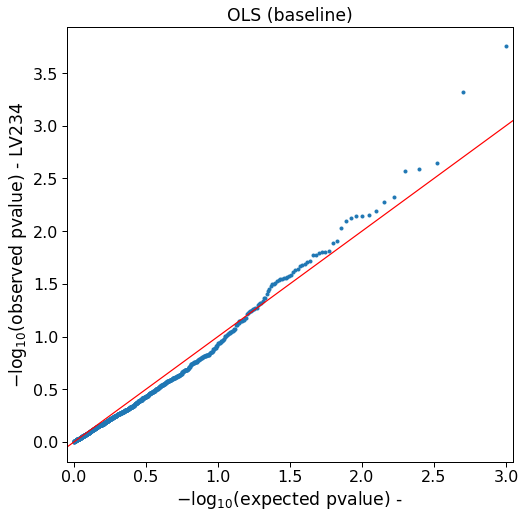

In [44]:
qqplot_unif(results)

#### Top genes in LV

In [45]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV234,gene_band
HIST1H4E,7.379845,6p22.2
HIST1H3B,7.293635,6p22.2
HIST4H4,6.929394,12p12.3
HIST1H3H,6.863106,6p22.1
HIST1H3D,4.568047,6p22.2
HIST1H2BC,4.078396,6p22.2
HIST1H2AE,4.009782,6p22.2
HIST1H2BF,3.963254,6p22.2
HIST1H2BD,3.862981,6p22.2
HIST1H2BK,3.662444,6p22.1


In [46]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

6p22.2     17
6p22.1      5
7q11.23     3
16p11.2     2
15q23       2
9q31.3      2
12p12.3     1
1q42.12     1
18q11.2     1
1q32.2      1
Name: gene_band, dtype: int64

### LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
278,LV847,0.060957,0.141972,0.429359,0.667676,0.333838,random.pheno988
1546,LV847,-0.041420,0.142476,-0.290712,0.771281,0.614359,random.pheno589
2791,LV847,-0.131236,0.142065,-0.923773,0.355639,0.822180,random.pheno385
3417,LV847,0.012524,0.142142,0.088110,0.929792,0.464896,random.pheno5
4586,LV847,-0.061619,0.142218,-0.433268,0.664835,0.667583,random.pheno74


#### Mean type I errors at different thresholds

In [51]:
show_prop(results, 0.01)

0.021

In [52]:
show_prop(results, 0.05)

0.065

In [53]:
show_prop(results, 0.10)

0.123

In [54]:
show_prop(results, 0.15)

0.189

In [55]:
show_prop(results, 0.20)

0.231

#### QQplot

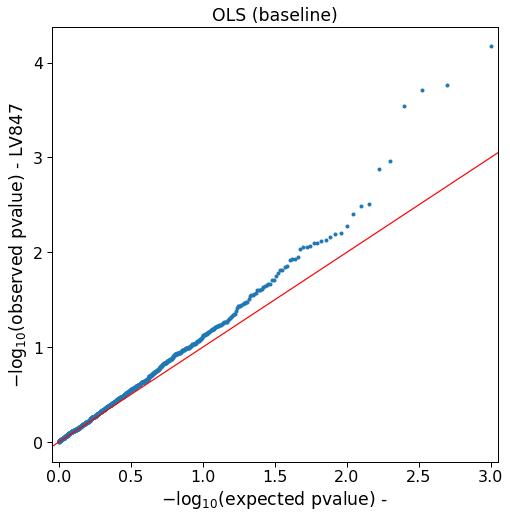

In [56]:
qqplot_unif(results)

### LV45

In [57]:
lv_code = "LV45"

In [58]:
results = dfs[dfs["lv"] == lv_code]

In [59]:
results.shape

(1000, 7)

In [60]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
943,LV45,-0.234949,0.141825,-1.656609,0.097647,0.951176,random.pheno988
1238,LV45,0.080735,0.142318,0.567282,0.570542,0.285271,random.pheno589
2167,LV45,0.119924,0.141938,0.844903,0.398196,0.199098,random.pheno385
3551,LV45,-0.038409,0.141983,-0.270516,0.786772,0.606614,random.pheno5
4424,LV45,-0.009205,0.142060,-0.064799,0.948336,0.525832,random.pheno74


#### Mean type I errors at different thresholds

In [61]:
show_prop(results, 0.01)

0.012

In [62]:
show_prop(results, 0.05)

0.068

In [63]:
show_prop(results, 0.10)

0.132

In [64]:
show_prop(results, 0.15)

0.183

In [65]:
show_prop(results, 0.20)

0.228

#### QQplot

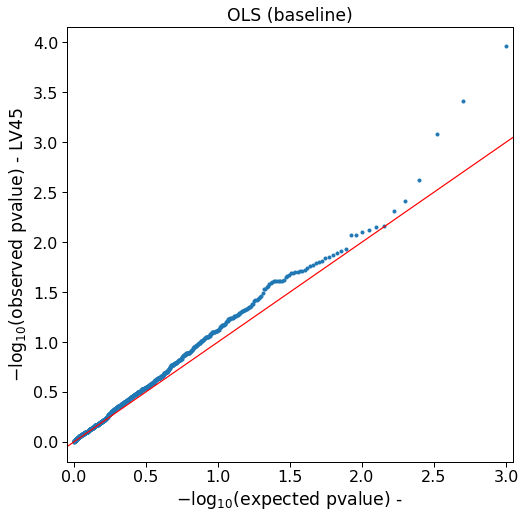

In [66]:
qqplot_unif(results)

### LV800

In [67]:
lv_code = "LV800"

In [68]:
results = dfs[dfs["lv"] == lv_code]

In [69]:
results.shape

(1000, 7)

In [70]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
99,LV800,0.187133,0.154027,1.214938,0.224434,0.112217,random.pheno988
1394,LV800,0.019546,0.154291,0.126680,0.899197,0.449599,random.pheno589
2784,LV800,-0.139643,0.154077,-0.906320,0.364800,0.817600,random.pheno385
3708,LV800,-0.102996,0.154082,-0.668450,0.503870,0.748065,random.pheno5
4325,LV800,0.032111,0.154249,0.208177,0.835097,0.417549,random.pheno74


#### Mean type I errors at different thresholds

In [71]:
show_prop(results, 0.01)

0.022

In [72]:
show_prop(results, 0.05)

0.066

In [73]:
show_prop(results, 0.10)

0.102

In [74]:
show_prop(results, 0.15)

0.151

In [75]:
show_prop(results, 0.20)

0.198

#### QQplot

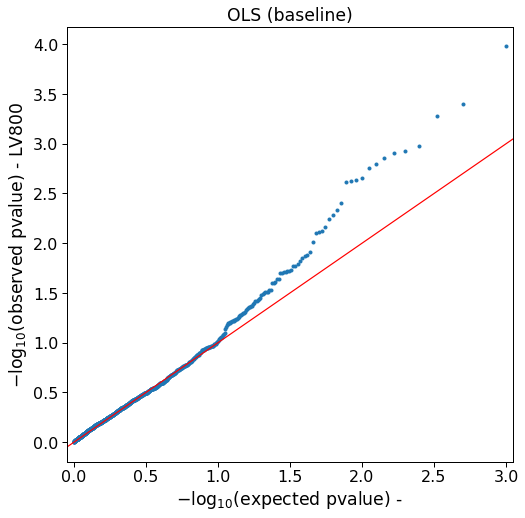

In [76]:
qqplot_unif(results)

### LV914

This one is not corrected here, I analyze it below.

### LV189

In [77]:
lv_code = "LV189"

In [78]:
results = dfs[dfs["lv"] == lv_code]

In [79]:
results.shape

(1000, 7)

In [80]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
929,LV189,-0.208970,0.136930,-1.526110,0.127032,0.936484,random.pheno988
1062,LV189,0.190048,0.137184,1.385352,0.165993,0.082996,random.pheno589
2297,LV189,0.051232,0.136974,0.374024,0.708399,0.354199,random.pheno385
3335,LV189,0.040874,0.137051,0.298238,0.765532,0.382766,random.pheno5
4377,LV189,0.013562,0.137036,0.098966,0.921169,0.460584,random.pheno74


#### Mean type I errors at different thresholds

In [81]:
show_prop(results, 0.01)

0.022

In [82]:
show_prop(results, 0.05)

0.073

In [83]:
show_prop(results, 0.10)

0.127

In [84]:
show_prop(results, 0.15)

0.18

In [85]:
show_prop(results, 0.20)

0.23

#### QQplot

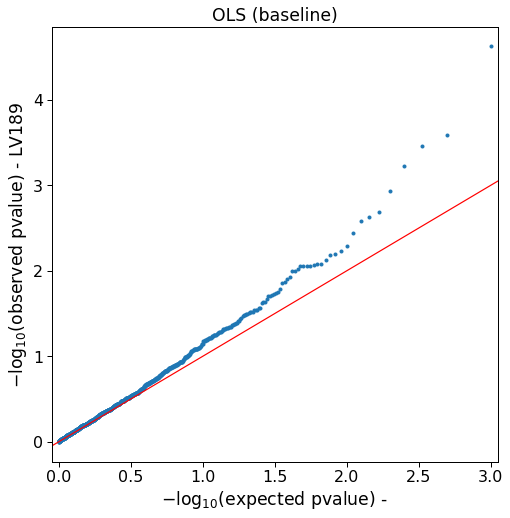

In [86]:
qqplot_unif(results)

## LVs with expected mean type I error

Here I make sure the well calibrated LVs in the OLS model are still well calibrated here.

In [87]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
334,LV40,0.018,0.049,0.097
828,LV845,0.012,0.049,0.093
431,LV488,0.012,0.049,0.099
767,LV790,0.013,0.049,0.099
324,LV391,0.013,0.049,0.096
838,LV854,0.016,0.049,0.086
843,LV859,0.013,0.049,0.086
760,LV784,0.011,0.049,0.082
754,LV779,0.011,0.049,0.091
251,LV325,0.015,0.049,0.095


Here I'm manually selecting from this list, since I want those that are well calibrated across different p-value thresholds.

### LV924

In [88]:
lv_code = "LV924"

In [89]:
results = dfs[dfs["lv"] == lv_code]

In [90]:
results.shape

(1000, 7)

In [91]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
520,LV924,-0.024983,0.126633,-0.197291,0.843606,0.578197,random.pheno988
1679,LV924,-0.082500,0.126848,-0.650384,0.515467,0.742266,random.pheno589
2502,LV924,-0.012369,0.126714,-0.097615,0.922241,0.538879,random.pheno385
3337,LV924,0.037117,0.126748,0.292840,0.769654,0.384827,random.pheno5
4928,LV924,-0.276650,0.126795,-2.181872,0.029155,0.985422,random.pheno74


#### Mean type I errors at different thresholds

In [92]:
show_prop(results, 0.01)

0.009

In [93]:
show_prop(results, 0.05)

0.043

In [94]:
show_prop(results, 0.10)

0.092

In [95]:
show_prop(results, 0.15)

0.14

In [96]:
show_prop(results, 0.20)

0.177

#### QQplot

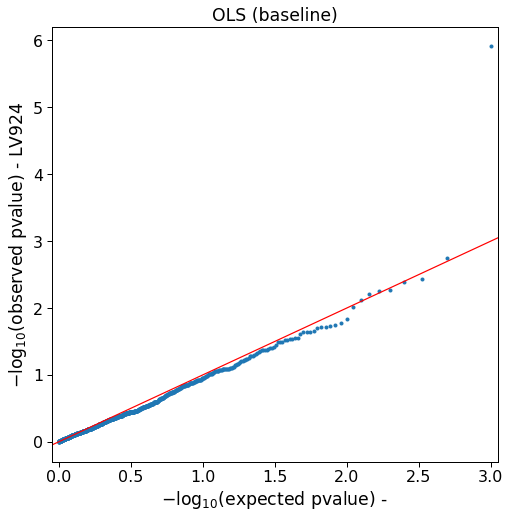

In [97]:
qqplot_unif(results)

Hm, well calibrated in general, but with one small pvalue.

### LV675

In [98]:
lv_code = "LV675"

In [99]:
results = dfs[dfs["lv"] == lv_code]

In [100]:
results.shape

(1000, 7)

In [101]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
928,LV675,-0.191674,0.126134,-1.519607,0.128659,0.935670,random.pheno988
1436,LV675,0.001291,0.126385,0.010213,0.991851,0.495926,random.pheno589
2165,LV675,0.107253,0.126235,0.849629,0.395563,0.197782,random.pheno385
3781,LV675,-0.111565,0.126241,-0.883745,0.376867,0.811567,random.pheno5
4348,LV675,0.019354,0.126364,0.153163,0.878275,0.439137,random.pheno74


#### Mean type I errors at different thresholds

In [102]:
show_prop(results, 0.01)

0.01

In [103]:
show_prop(results, 0.05)

0.05

In [104]:
show_prop(results, 0.10)

0.097

In [105]:
show_prop(results, 0.15)

0.142

In [106]:
show_prop(results, 0.20)

0.196

#### QQplot

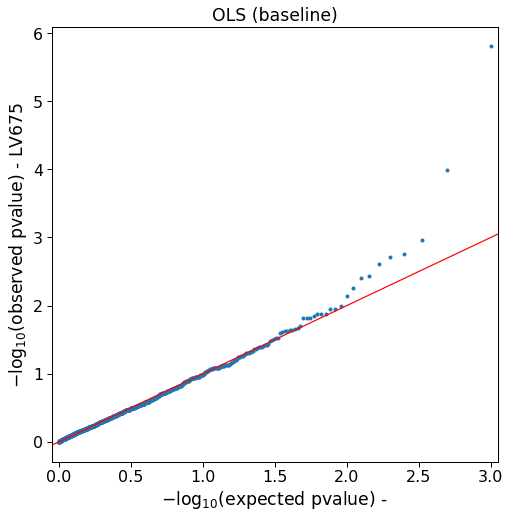

In [107]:
qqplot_unif(results)

### LV691

In [108]:
lv_code = "LV691"

In [109]:
results = dfs[dfs["lv"] == lv_code]

In [110]:
results.shape

(1000, 7)

In [111]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
104,LV691,0.150528,0.125778,1.196780,0.231436,0.115718,random.pheno988
1850,LV691,-0.144710,0.126008,-1.148421,0.250838,0.874581,random.pheno589
2316,LV691,0.040874,0.125878,0.324712,0.745410,0.372705,random.pheno385
3201,LV691,0.087899,0.125878,0.698286,0.485024,0.242512,random.pheno5
4128,LV691,0.112654,0.125995,0.894117,0.371293,0.185646,random.pheno74


#### Mean type I errors at different thresholds

In [112]:
show_prop(results, 0.01)

0.013

In [113]:
show_prop(results, 0.05)

0.048

In [114]:
show_prop(results, 0.10)

0.096

In [115]:
show_prop(results, 0.15)

0.157

In [116]:
show_prop(results, 0.20)

0.197

#### QQplot

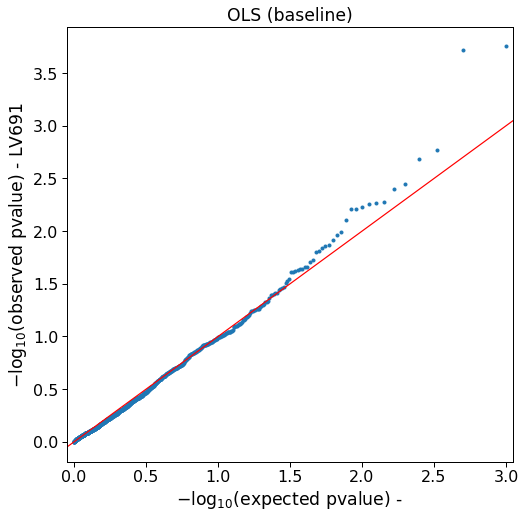

In [117]:
qqplot_unif(results)

# GLS model - LVs with high mean type I error

## LV914

In [118]:
lv_code = "LV914"

In [119]:
results = dfs[dfs["lv"] == lv_code]

In [120]:
results.shape

(1000, 7)

In [121]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
66,LV914,0.180871,0.127823,1.415010,0.157114,0.078557,random.pheno988
1518,LV914,-0.029696,0.128016,-0.231967,0.816571,0.591714,random.pheno589
2783,LV914,-0.114162,0.127962,-0.892153,0.372344,0.813828,random.pheno385
3400,LV914,0.016496,0.127889,0.128985,0.897374,0.448687,random.pheno5
4531,LV914,-0.038452,0.128005,-0.300396,0.763885,0.618058,random.pheno74


### Mean type I errors at different thresholds

In [122]:
show_prop(results, 0.01)

0.034

In [123]:
show_prop(results, 0.05)

0.105

In [124]:
show_prop(results, 0.10)

0.176

In [125]:
show_prop(results, 0.15)

0.235

In [126]:
show_prop(results, 0.20)

0.292

### QQplot

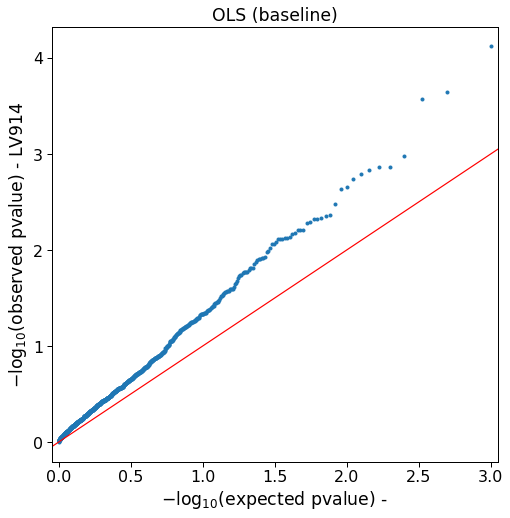

In [127]:
qqplot_unif(results)

### Top genes in LV

In [128]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV914,gene_band
IL23A,6.258103,12q13.3
AKT2,5.248118,19q13.2
HOXA5,2.588375,7p15.2
LAMA2,2.255515,6q22.33
RNF8,1.722023,6p21.2
PAPOLG,1.398173,2p16.1
MBD4,1.376868,3q21.3
TBK1,1.328314,12q14.2
CBLB,1.305683,3q13.11
DOK1,1.219439,2p13.1


In [129]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

13q13.3     2
7p15.2      2
19q13.2     2
3q25.33     1
2q35        1
19q13.33    1
12q13.11    1
19q13.32    1
6p22.3      1
8q13.3      1
Name: gene_band, dtype: int64

## LV816

In [130]:
lv_code = "LV816"

In [131]:
results = dfs[dfs["lv"] == lv_code]

In [132]:
results.shape

(1000, 7)

In [133]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
2,LV816,0.327034,0.126016,2.595168,0.009476,0.004738,random.pheno988
1183,LV816,0.095954,0.126311,0.759664,0.447483,0.223742,random.pheno589
2705,LV816,-0.081603,0.126166,-0.646795,0.517788,0.741106,random.pheno385
3594,LV816,-0.046484,0.126172,-0.368418,0.712573,0.643713,random.pheno5
3998,LV816,0.201682,0.126273,1.597186,0.110273,0.055137,random.pheno74


### Mean type I errors at different thresholds

In [134]:
show_prop(results, 0.01)

0.032

In [135]:
show_prop(results, 0.05)

0.102

In [136]:
show_prop(results, 0.10)

0.152

In [137]:
show_prop(results, 0.15)

0.218

In [138]:
show_prop(results, 0.20)

0.264

### QQplot

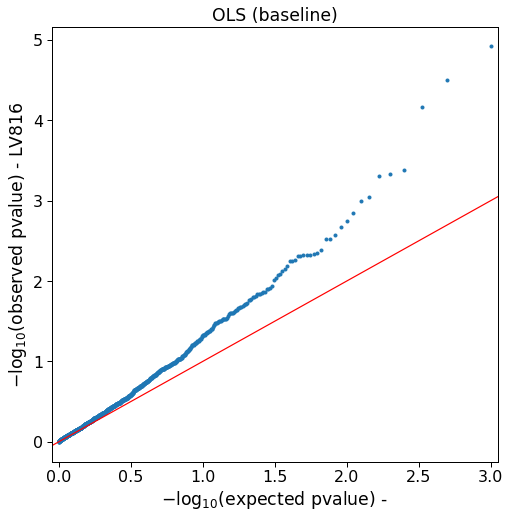

In [139]:
qqplot_unif(results)

### Top genes in LV

In [140]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV816,gene_band
ATP1B2,5.753339,17p13.1
PON2,4.335049,7q21.3
ALDOC,4.301768,17q11.2
GLUD1,3.721127,10q23.2
GJB6,3.628673,13q12.11
CLDN10,3.373320,13q32.1
SLC15A2,3.123544,3q13.33
GLUL,3.063349,1q25.3
SLC4A4,3.023711,4q13.3
SLC48A1,2.848704,12q13.11


In [141]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

17q11.2     2
17p13.1     2
14q24.3     1
11p15.4     1
17p12       1
11p15.1     1
5q31.2      1
14q32.33    1
19q13.33    1
8q13.1      1
Name: gene_band, dtype: int64

## LV588

In [142]:
lv_code = "LV588"

In [143]:
results = dfs[dfs["lv"] == lv_code]

In [144]:
results.shape

(1000, 7)

In [145]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
882,LV588,-0.160182,0.126061,-1.270670,0.203892,0.898054,random.pheno988
1056,LV588,0.182609,0.126284,1.446023,0.148219,0.074110,random.pheno589
2378,LV588,0.024301,0.126162,0.192616,0.847266,0.423633,random.pheno385
3927,LV588,-0.231263,0.126135,-1.833454,0.066781,0.966609,random.pheno5
4180,LV588,0.084238,0.126289,0.667027,0.504779,0.252389,random.pheno74


### Mean type I errors at different thresholds

In [146]:
show_prop(results, 0.01)

0.016

In [147]:
show_prop(results, 0.05)

0.096

In [148]:
show_prop(results, 0.10)

0.155

In [149]:
show_prop(results, 0.15)

0.213

In [150]:
show_prop(results, 0.20)

0.273

### QQplot

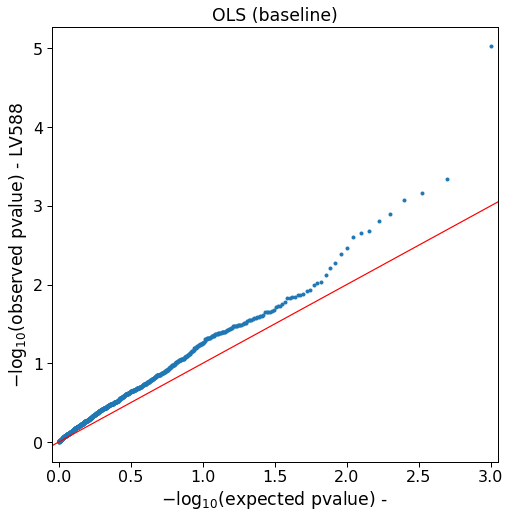

In [151]:
qqplot_unif(results)

### Top genes in LV

In [152]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV588,gene_band
ASB8,4.260123,12q13.11
PEX1,3.746568,7q21.2
BLOC1S3,3.451845,19q13.32
VLDLR,3.393852,9p24.2
ATP8A2,2.129880,13q12.13
SLC7A6,2.108679,16q22.1
MFN1,2.061924,3q26.33
ZMYM2,2.055472,13q12.11
DAAM1,1.960115,14q23.1
CES3,1.888471,16q22.1


In [153]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

8p23.1      2
7q21.2      2
10q26.13    2
16q22.1     2
4q21.1      2
1p35.3      1
11q21       1
3q13.2      1
1p31.1      1
2q23.1      1
Name: gene_band, dtype: int64

# Conclusions

When using the full correlation matrix (all gene-gene correlations in a chromosome), it improves a little bit the mean type I error over the 5mb distance correlation matrix (only across genes within 5mb of distance) from 0.0557 to 0.0544.

However, this difference is very small and, importantely, using the full correlation matrix does not fix the problem with LVs like LV914.